In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
try:
    import pcmdpy_gpu as ppy
except:
    import pcmdpy as ppy
from tqdm import tqdm
%matplotlib inline

In [2]:
plt.style.use('cook')

In [3]:
filters = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(filters, mag_system='ab')
driv = ppy.driver.Driver(iso_model, gpu=ppy.gpu_utils._GPU_ACTIVE)

Please wait while the GPU states are initialized

In [4]:
gal = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.SingleFeH(), 
    ppy.dustmodels.SingleDust(dust_frac=0.5),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.VariableDistance(),
)

In [5]:
p = {}
p[0] = np.array([-0.5, -0.5, 3.0, 3.0, 25.0])
p[1] = p[0] + np.array([0.5, 0., 0., 0., 0.])
p[2] = p[0] + np.array([-0.5, 0., 0., 0., 0.])
p[3] = p[0] + np.array([0., 0.5, 0., 0., 0.])
p[4] = p[0] + np.array([0., -0.5, 0., 0., 0.])
p[5] = p[0] + np.array([0., 0., 0., 9.0, 0.])
p[6] = p[0] + np.array([0., 0., 0., -2.0, 0.])
p[7] = p[0] + np.array([0., 0., 0.5, 0., 0.])
p[8] = p[0] + np.array([0., 0., -0.5, 0., 0.])
p[9] = p[0] + np.array([0., 0., 0., 0., -1.25])
p[10] = p[0] + np.array([0., 0., 0., 0., +1.25])

In [6]:
if ppy.gpu_utils._GPU_ACTIVE:
    Nim = 1024
else:
    print('Warning: Using CPU only')
    Nim = 128
pcmds = {}
for i in tqdm(range(0, 11)):
    gal.set_params(p[i])
    pcmds[i] = driv.simulate(gal, Nim, shot_noise=False)[0]

100%|██████████| 11/11 [00:24<00:00,  2.14s/it]


In [27]:
titles = {}
titles[0] = 'Baseline Model'
titles[1] = '[Fe/H] + 0.5'
titles[2] = '[Fe/H] - 0.5'
titles[3] = '$\log$ E(B-V) + 0.5'
titles[4] = '$\log$ E(B-V) - 0.5'
titles[5] = r'$\tau$ x 3'
titles[6] = r'$\tau$ x 1/3'
titles[7] = r'$\log \mathrm{N_{pix}}$ + 0.5'
titles[8] = r'$\log \mathrm{N_{pix}}$ - 0.5'
titles[9] = r'$\mu_d$ - 1.25'
titles[10] = r'$\mu_d$ + 1.25'

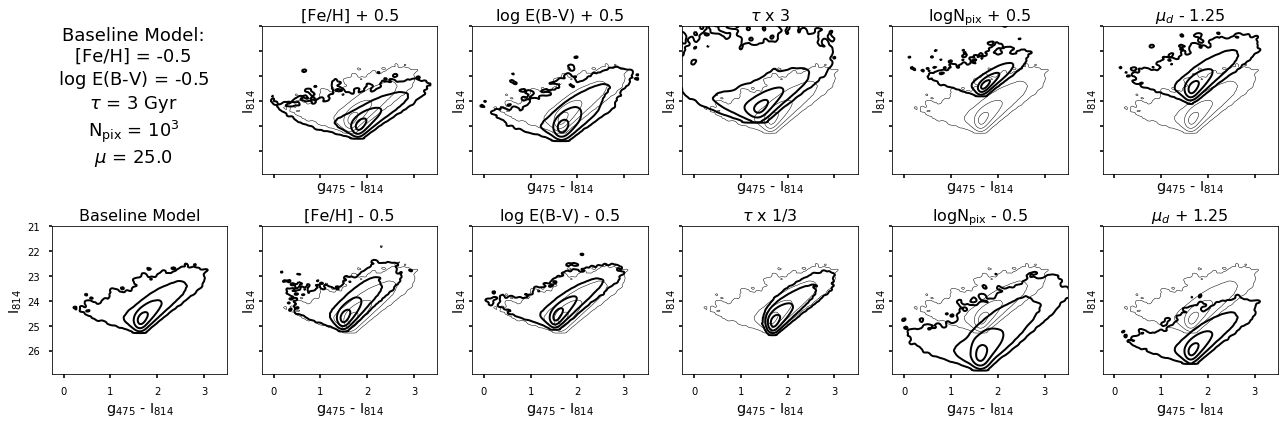

In [29]:
f, axes = plt.subplots(figsize=(18, 6), ncols=6, nrows=2, sharex=True, sharey=True)
axes = axes.T.flatten()
bins = [np.arange(21, 27, 0.05), np.arange(-0.25, 3.51, 0.05)]

model_text = r"""Baseline Model:
[Fe/H] = -0.5
$\log$ E(B-V) = -0.5
$\tau$ = 3 Gyr
$\mathrm{N_{pix}}$ = 10$^3$
$\mu$ = 25.0
"""

axes[0].axis('off')
axes[0].text(1.5, 21, model_text, verticalalignment='top', horizontalalignment='center',
            fontsize=18)

ppy.plotting.plot_pcmd_contours(pcmds[0], ax=axes[1], color='k')

for i, a in enumerate(axes[1:]):
    if i > 0:
        ppy.plotting.plot_pcmd_contours(pcmds[0], ax=a, color='k', contour_kwargs={'linewidths': .5})
        ppy.plotting.plot_pcmd_contours(pcmds[i], ax=a, color='k')
#     else:
#         ppy.plotting.plot_pcmd(pcmds[i], ax=a, bins=bins)        
    ppy.plotting.plot_isochrone(iso_model, dmod=25.0, axes=a, zorder=-1, alpha=0.)
    a.set_aspect('auto')
    if i > 2:
        plt.setp(a.get_yticklabels(), visible=False)
    if (i % 2):
        plt.setp(a.get_xticklabels(), visible=False)
    a.set_title(titles[i])
axes.flatten()[-1].set_ybound([bins[0][0], bins[0][-1]])
axes.flatten()[-1].set_xbound([bins[1][0], bins[1][-1]])
plt.tight_layout()
if ppy.gpu_utils._GPU_ACTIVE:
    plt.savefig('figures/paper1/param_variance.pdf')